<a href="https://colab.research.google.com/github/PangyourQA/The-Use-of-BiLSTM-and-CNN-LSTM-in-prediction-of-S-P-500-UTM-Master-Thesis-/blob/main/Coding/Master_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import gc
import os
import random
import copy
import matplotlib.pyplot as plt
import pandas
import statsmodels
import math
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Bidirectional, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from datetime import datetime

In [ ]:
!pip install pyts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 20.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField

df = yf.download("^GSPC", start="2015-01-01", end="2023-01-01")

[*********************100%***********************]  1 of 1 completed


(2014,)


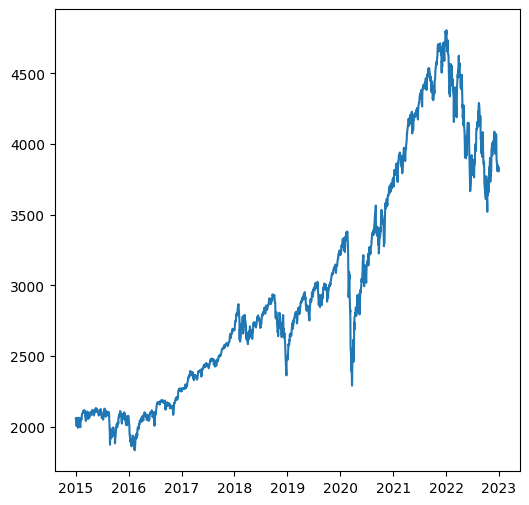

In [ ]:
df_1 = df.iloc[:, 4]
print(df_1.shape)
plt.figure(figsize=(6, 6))
plt.plot(df_1)

In [ ]:
df_1.describe()

,Open
,^GSPC
count,2014.000000
mean,2981.532615
std,812.280972
min,1833.400024
25%,2267.804993
50%,2797.790039
75%,3685.899963
max,4804.509766


<Axes: >

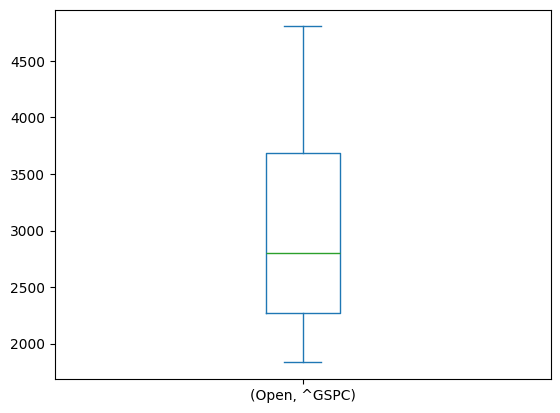

In [ ]:
df_1.plot.box()

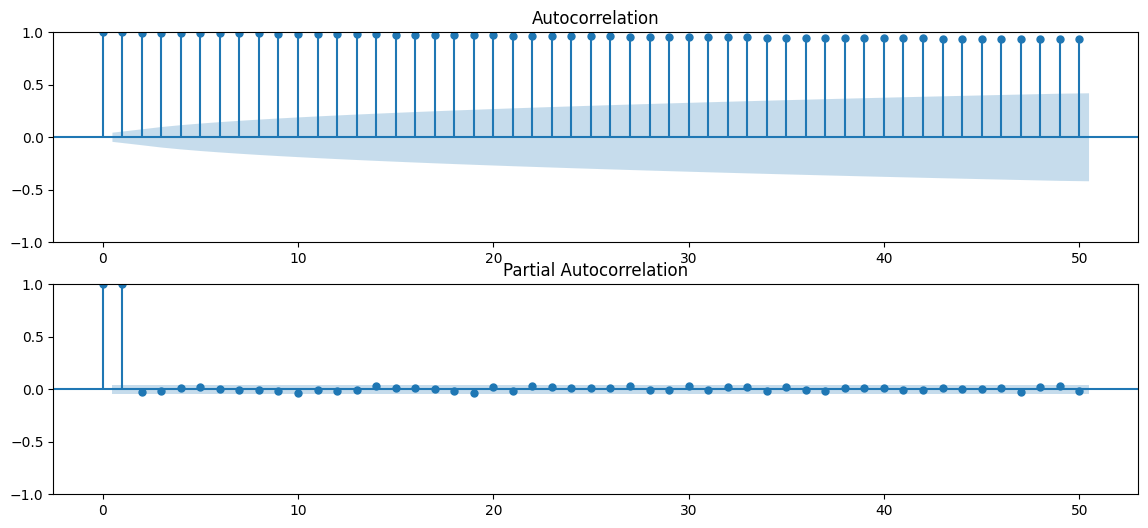

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(df_1, lags=50, ax=ax1)
ax2 = plot_pacf(df_1, lags=50, ax=ax2)
plt.show()

In [ ]:
df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,
2015-01-02,2058.199951,2058.199951,2072.360107,2046.040039,2058.899902,2708700000
2015-01-05,2020.579956,2020.579956,2054.439941,2017.339966,2054.439941,3799120000
2015-01-06,2002.609985,2002.609985,2030.250000,1992.439941,2022.150024,4460110000
2015-01-07,2025.900024,2025.900024,2029.609985,2005.550049,2005.550049,3805480000
2015-01-08,2062.139893,2062.139893,2064.080078,2030.609985,2030.609985,3934010000


In [ ]:
df.columns = df.columns.get_level_values(0)

In [ ]:
df.columns = df.columns.to_list()
df.columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [ ]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 4.4 MB/s eta 0:00:00


In [ ]:
df.isna().sum()

,,0
Price,Ticker,
Adj Close,^GSPC,0
Close,^GSPC,0
High,^GSPC,0
Low,^GSPC,0
Open,^GSPC,0
Volume,^GSPC,0
MA5,,2014
MA15,,2014
MA20,,2014


<ipython-input-29-580718035d78>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0['MA5'] = df_0['Adj Close'].rolling(window=5).mean()
<ipython-input-29-580718035d78>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0['MA15'] = df_0['Adj Close'].rolling(window=15).mean()
<ipython-input-29-580718035d78>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

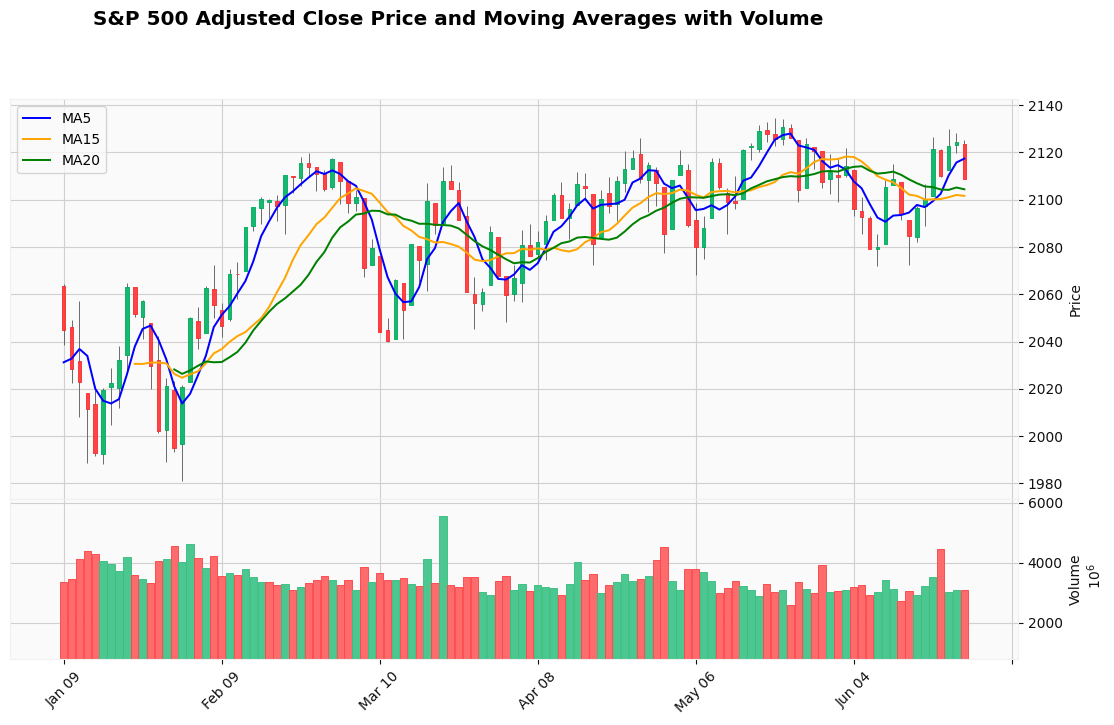

In [ ]:
import mplfinance as mpf


# Drop rows with missing values in required columns
df = df.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])
df_0 = df[0:120]

# Calculate moving averages
df_0['MA5'] = df_0['Adj Close'].rolling(window=5).mean()
df_0['MA15'] = df_0['Adj Close'].rolling(window=15).mean()
df_0['MA20'] = df_0['Adj Close'].rolling(window=20).mean()
df_0 = df_0[5:]

# Create a new DataFrame with the required columns for mplfinance
mpf_df = df_0[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# Create custom plots (moving averages)
add_plots = [
    mpf.make_addplot(df_0['MA5'], color='blue', label='MA5'),
    mpf.make_addplot(df_0['MA15'], color='orange', label='MA15'),
    mpf.make_addplot(df_0['MA20'], color='green', label='MA20')
]

# Plot using mplfinance
mpf.plot(
    mpf_df,
    type='candle',             # Candlestick chart
    volume=True,               # Include volume in the subplot below
    addplot=add_plots,         # Add moving averages
    title='S&P 500 Adjusted Close Price and Moving Averages with Volume',
    ylabel='Price',
    ylabel_lower='Volume',
    style='yahoo',             # Choose a predefined style
    figsize=(14, 8)
)

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


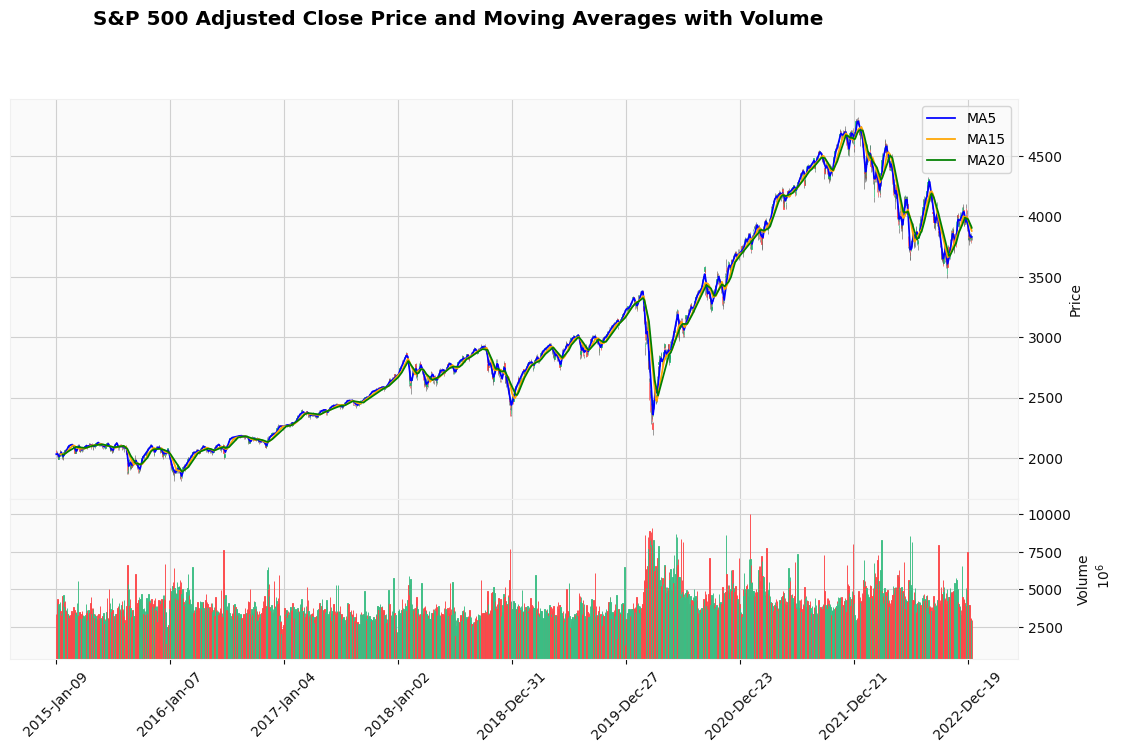

In [ ]:
df_0 = df

# Calculate moving averages
df_0['MA5'] = df_0['Adj Close'].rolling(window=5).mean()
df_0['MA15'] = df_0['Adj Close'].rolling(window=15).mean()
df_0['MA20'] = df_0['Adj Close'].rolling(window=20).mean()
df_0 = df_0[5:]

# Create a new DataFrame with the required columns for mplfinance
mpf_df = df_0[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# Create custom plots (moving averages)
add_plots = [
    mpf.make_addplot(df_0['MA5'], color='blue', label='MA5'),
    mpf.make_addplot(df_0['MA15'], color='orange', label='MA15'),
    mpf.make_addplot(df_0['MA20'], color='green', label='MA20')
]

# Plot using mplfinance
mpf.plot(
    mpf_df,
    type='candle',             # Candlestick chart
    volume=True,               # Include volume in the subplot below
    addplot=add_plots,         # Add moving averages
    title='S&P 500 Adjusted Close Price and Moving Averages with Volume',
    ylabel='Price',
    ylabel_lower='Volume',
    style='yahoo',             # Choose a predefined style
    figsize=(14, 8)
)

In [ ]:
df_0.to_excel('First processed Dataset.xlsx')

In [ ]:
df_diff=pd.DataFrame(np.diff(df_1['Adj Close']))

In [ ]:
result = adfuller(df_1['Adj Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.959447
p-value: 0.767766
Critical Test Statistics Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [ ]:
result = adfuller(df_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -14.081190
p-value: 0.000000
Critical Test Statistics Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.5 MB/s eta 0:00:00


In [ ]:
import pmdarima as pm
model = pm.auto_arima(df_1['Adj Close'], d=1, D=1,seasonal=True, m=12, trend='c',start_p=0, start_q=0, max_order=6, test='adf', stepwise=True, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=13.02 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=21299.966, Time=0.37 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=20755.550, Time=8.44 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=9.99 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=21281.694, Time=0.27 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=20456.647, Time=11.57 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=17.47 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=7.46 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=20476.795, Time=7.71 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=20449.442, Time=14.01 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=20739.257, Time=8.38 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=22.37 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=10.78 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=20450.705, Time=15.99 sec
 ARIMA(2,1,1)(2,1,0)[12]          

In [ ]:
import math
testing_data_len = math.ceil(len(df_1['Adj Close']) * .05)
testing_data_len

100

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df_1['Adj Close'].values.reshape(-1,1))
scaled_data

array([[0.0559094 ],
       [0.06462386],
       [0.07445714],
       ...,
       [0.65851832],
       [0.68077965],
       [0.67748392]])

In [ ]:
train_valid = scaled_data[:-testing_data_len, :]
len(train_valid)
training_data_len = math.ceil(len(train_valid) * .8)
training_data_len

1516

In [ ]:
train_data = train_valid[0:training_data_len,:]
X_train = []
y_train = []
#train_data[0:10,0]
for i in range(100, len(train_data)):
    X_train.append(train_data[i-100:i, 0])
    y_train.append(train_data[i, 0])

val_data = train_valid[training_data_len:,:]
X_val = []
y_val = []
for i in range(100, len(val_data)):
    X_val.append(val_data[i-100:i, 0])
    y_val.append(val_data[i, 0])

In [ ]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)

In [ ]:
print(X_train.shape)
print(X_val.shape)

(1416, 100)
(279, 100)


In [ ]:
#reshape the data for lstm
y_train.shape
# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1],1))
# [samples, subsequences, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 25, 4, 1))
X_train.shape

(1416, 25, 4, 1)

In [ ]:
X_val = np.reshape(X_val, (X_val.shape[0], 25, 4, 1))
X_val.shape

(279, 25, 4, 1)

In [ ]:
model_CNN_Bilstm = Sequential()
model_CNN_Bilstm.add(TimeDistributed(Conv1D(32, 1), input_shape=(None, X_train.shape[2], X_train.shape[3])))
model_CNN_Bilstm.add(TimeDistributed(MaxPooling1D()))
model_CNN_Bilstm.add(TimeDistributed(Flatten()))
model_CNN_Bilstm.add(Bidirectional(LSTM(50))) #newly added bidirectional
model_CNN_Bilstm.add(Dense(25)) #newly added..
model_CNN_Bilstm.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Define the CNN + LSTM model
model_CNN_LSTM = Sequential()
model_CNN_LSTM.add(TimeDistributed(Conv1D(32, 1), input_shape=(None, X_train.shape[2], X_train.shape[3])))
model_CNN_LSTM.add(TimeDistributed(MaxPooling1D()))
model_CNN_LSTM.add(TimeDistributed(Flatten()))
model_CNN_LSTM.add(LSTM(50))  # Replace Bidirectional LSTM with regular LSTM
model_CNN_LSTM.add(Dense(25))  # Fully connected layer
model_CNN_LSTM.add(Dense(1))  # Output layer

In [ ]:
# Define the BiLSTM model
model_BiLSTM = Sequential()
model_BiLSTM.add(Bidirectional(LSTM(50), input_shape=(X_train.shape[1], X_train.shape[2])))  # BiLSTM layer
model_BiLSTM.add(Dense(25))  # Fully connected layer
model_BiLSTM.add(Dense(1))  # Output layer

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model_CNN_Bilstm.compile(loss='mse', optimizer='adam')
model_CNN_LSTM.compile(loss='mse', optimizer='adam')
model_BiLSTM.compile(loss='mse', optimizer='adam')

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

model_CNN_Bilstm.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=100, callbacks=[early_stopping])

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0027 - val_loss: 4.9054e-04
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.5635e-04 - val_loss: 0.0012
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 1.3896e-04 - val_loss: 6.3588e-04
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 1.5873e-04 - val_loss: 5.1276e-04
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.9014e-04 - val_loss: 0.0010
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.5686e-04 - val_loss: 4.4771e-04
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.3472e-04 - val_loss: 6.2075e-04
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 1.7813e-04 - val_loss: 5.1987e-04
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 1.2781e-04 - val_loss: 4.6802e-04
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.8307e-04 - val_loss: 6.2348e-04
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.7408e-04

In [ ]:
model_CNN_Bilstm.save('model_CNN_BiLSTM_Forecast.h5')
model_CNN_Bilstm.save('model_CNN_BiLSTM_Forecast.keras')

In [ ]:
model_CNN_LSTM.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=100, callbacks=[early_stopping])

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 6.5751e-04 - val_loss: 0.0019
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.9978e-04 - val_loss: 0.0011
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.2358e-04 - val_loss: 0.0036
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.5343e-04 - val_loss: 7.6071e-04
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.5517e-04 - val_loss: 0.0023
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.0054e-04 - val_loss: 6.4643e-04


In [ ]:
model_CNN_LSTM.save('model_CNN_LSTM_Forecast.h5')
model_CNN_LSTM.save('model_CNN_LSTM_Forecast.keras')

In [ ]:
model_BiLSTM.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=100, callbacks=[early_stopping])

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.8824e-04 - val_loss: 0.0017
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 9.7326e-04 - val_loss: 0.0015
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.2574e-04 - val_loss: 0.0012
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.4825e-04 - val_loss: 9.7896e-04
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.5417e-04 - val_loss: 0.0012
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.9543e-04 - val_loss: 7.7289e-04
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.9503e-04 - val_loss: 7.2356e-04


In [ ]:
model_BiLSTM.save('model_BiLSTM_Forecast.h5')
model_BiLSTM.save('model_BiLSTM_Forecast.keras')

In [ ]:
print(model_CNN_Bilstm.summary())
print(model_CNN_LSTM.summary())
print(model_BiLSTM.summary())

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_12                  │ (None, None, 4, 32)         │              64 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_13                  │ (None, None, 2, 32)         │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_14                  │ (None, None, 64)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 100)                 │          46,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 25)                  │           2,525 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 145,847 (569.72 KB)

 Trainable params: 48,615 (189.90 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 97,232 (379.82 KB)

None


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_15                  │ (None, None, 4, 32)         │              64 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_16                  │ (None, None, 2, 32)         │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_17                  │ (None, None, 64)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 50)                  │          23,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,097 (285.54 KB)

 Trainable params: 24,365 (95.18 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 48,732 (190.36 KB)

None


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional)      │ (None, 100)                 │          22,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 25)                  │           2,525 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,655 (287.72 KB)

 Trainable params: 24,551 (95.90 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 49,104 (191.82 KB)

None


In [ ]:
df_2 = df_1.reset_index()
df_2.head()

,Date,Adj Close,MA5,MA15,MA20
0,2015-01-30,1994.989990,2021.008032,2026.276025,2028.178510
1,2015-02-02,2020.849976,2013.760010,2024.678687,2026.311011
2,2015-02-03,2050.030029,2017.856006,2026.130021,2027.783514
3,2015-02-04,2041.510010,2025.726001,2027.362020,2029.728516
4,2015-02-05,2062.520020,2033.980005,2030.778687,2031.559515


In [ ]:
valid_data = train_valid[training_data_len-100:,:]
X_test = []
y_test = df_2.iloc[training_data_len:-testing_data_len, :]['Adj Close'] #not scaled data
for i in range(100, len(valid_data)):
    X_test.append(valid_data[i-100:i,0])

In [ ]:
len(train_valid)

1895

In [ ]:
y_test = np.array(y_test)

In [ ]:
y_test.shape

(379,)

In [ ]:
X_test = np.array(X_test)

In [ ]:
X_test = np.reshape(X_test, (X_test.shape[0], 25, 4, 1))
X_test.shape

(379, 25, 4, 1)

In [ ]:
predictions_CNN_BiLSTM = model_CNN_Bilstm.predict(X_test)
predictions_CNN_BiLSTM = scaler.inverse_transform(predictions_CNN_BiLSTM)
predictions_CNN_LSTM = model_CNN_LSTM.predict(X_test)
predictions_CNN_LSTM = scaler.inverse_transform(predictions_CNN_LSTM)
predictions_BiLSTM = model_BiLSTM.predict(X_test)
predictions_BiLSTM = scaler.inverse_transform(predictions_BiLSTM)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [ ]:
rmse_CNNBiLSTM = np.sqrt(np.mean((predictions_CNN_BiLSTM - y_test)**2))
rmse_CNNLSTM = np.sqrt(np.mean((predictions_CNN_LSTM - y_test)**2))
rmse_BiLSTM = np.sqrt(np.mean((predictions_BiLSTM - y_test)**2))
print('The RMSE of CNN_BiLSTM is:')
print(rmse_CNNBiLSTM)
print('The RMSE of CNN_LSTM is:')
print(rmse_CNNLSTM)
print('The RMSE of BiLSTM is:')
print(rmse_BiLSTM)

The RMSE of CNN_BiLSTM is:
378.1239150023012
The RMSE of CNN_LSTM is:
385.8432340003735
The RMSE of BiLSTM is:
377.41291809367374


In [ ]:
def MAPE(y_actual, y_pred):
    y_actual, y_pred = np.array(y_actual), np.array(y_pred)

    # Handle division by zero by masking or filtering out zero values in y_actual
    if np.any(y_actual == 0):
        raise ValueError("Actual values (y_actual) contain zero, causing division by zero in MAPE calculation.")

    mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
    return mape

In [ ]:
MAPE_CNNBiLSTM = MAPE(y_test, predictions_CNN_BiLSTM)
MAPE_CNNLSTM = MAPE(y_test, predictions_CNN_LSTM)
MAPE_BiLSTM = MAPE(y_test, predictions_BiLSTM)
print('The MAPE of CNN_BiLSTM is:')
print(MAPE_CNNBiLSTM)
print('The MAPE of CNN_LSTM is:')
print(MAPE_CNNLSTM)
print('The MAPE of BiLSTM is:')
print(MAPE_BiLSTM)

The MAPE of CNN_BiLSTM is:
7.229995161983911
The MAPE of CNN_LSTM is:
7.467689701870621
The MAPE of BiLSTM is:
7.183110763972304


<ipython-input-46-99ea09690f96>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions_CNN_BiLSTM


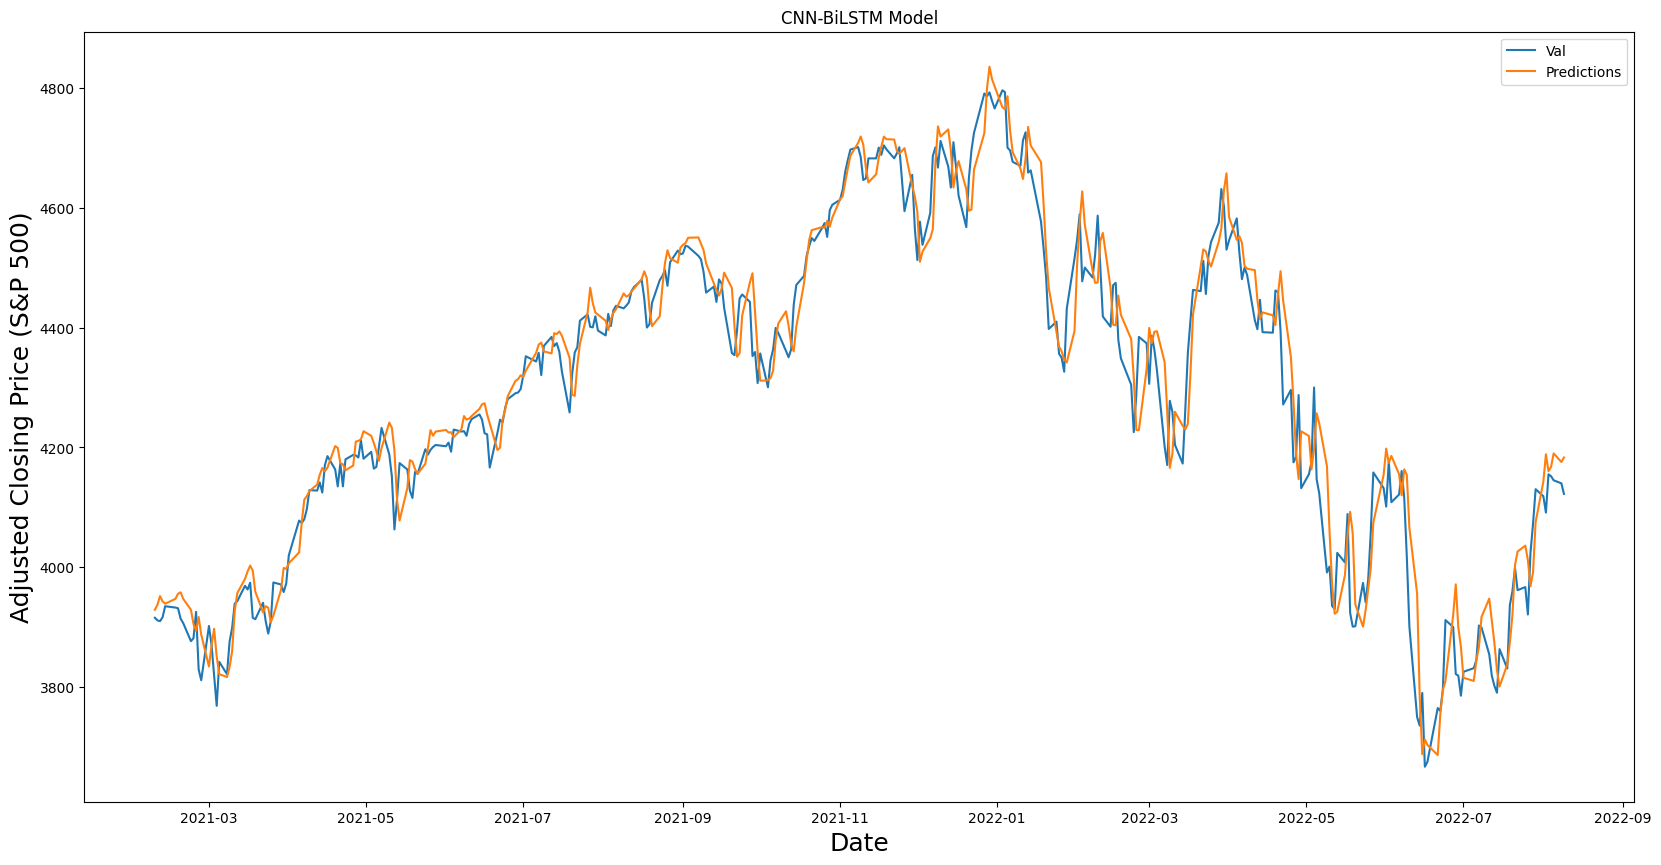

In [ ]:
train = df_1[:training_data_len]
valid = df_1[training_data_len:-testing_data_len]
valid['predictions'] = predictions_CNN_BiLSTM
# closing_price_sc = go.Scatter(x=train['date'], y=train['closing_price'])
# layout = go.Layout(title='Closing Price', xaxis=dict(title='Date'), yaxis=dict(title='CP'),width=1000, height=600)
# fig = go.Figure(data=[closing_price_sc], layout=layout)
# iplot(fig)
# print(valid.head())
plt.figure(figsize=(20,10))
plt.title('CNN-BiLSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adjusted Closing Price (S&P 500)', fontsize=18)
# plt.plot(train['closing_price'])
plt.plot(valid[['Adj Close', 'predictions']])
plt.legend(['Val', 'Predictions'], loc='upper right')
plt.show()


<ipython-input-47-a27bba0d7a13>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions_CNN_LSTM


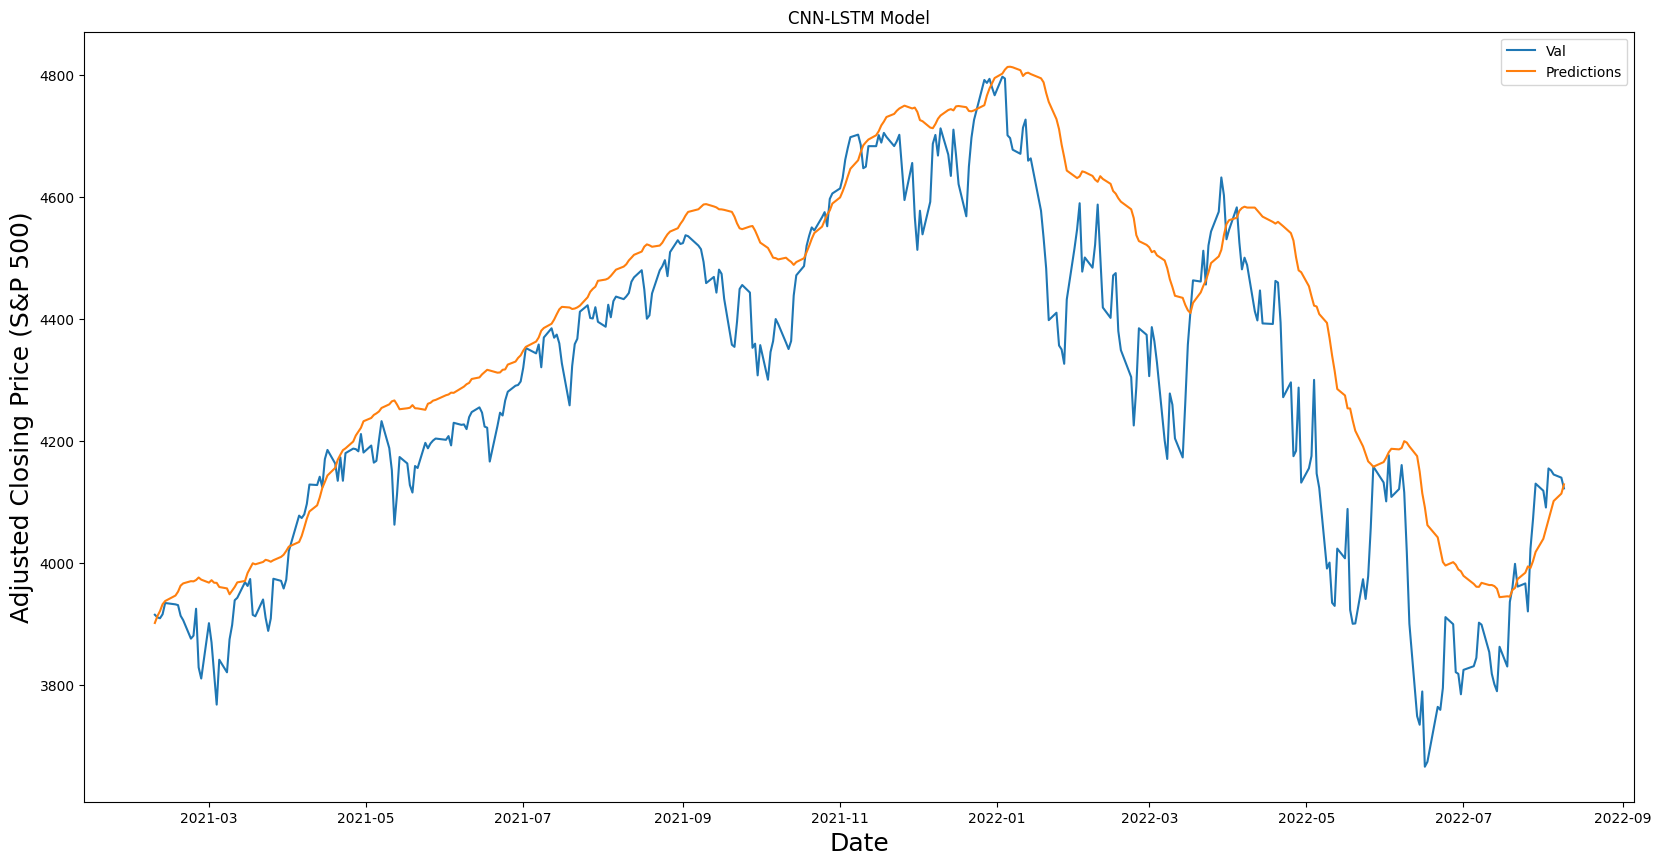

In [ ]:
train = df_1[:training_data_len]
valid = df_1[training_data_len:-testing_data_len]
valid['predictions'] = predictions_CNN_LSTM
# closing_price_sc = go.Scatter(x=train['date'], y=train['closing_price'])
# layout = go.Layout(title='Closing Price', xaxis=dict(title='Date'), yaxis=dict(title='CP'),width=1000, height=600)
# fig = go.Figure(data=[closing_price_sc], layout=layout)
# iplot(fig)
# print(valid.head())
plt.figure(figsize=(20,10))
plt.title('CNN-LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adjusted Closing Price (S&P 500)', fontsize=18)
# plt.plot(train['closing_price'])
plt.plot(valid[['Adj Close', 'predictions']])
plt.legend(['Val', 'Predictions'], loc='upper right')
plt.show()

<ipython-input-48-f13185d2b8ed>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions_BiLSTM


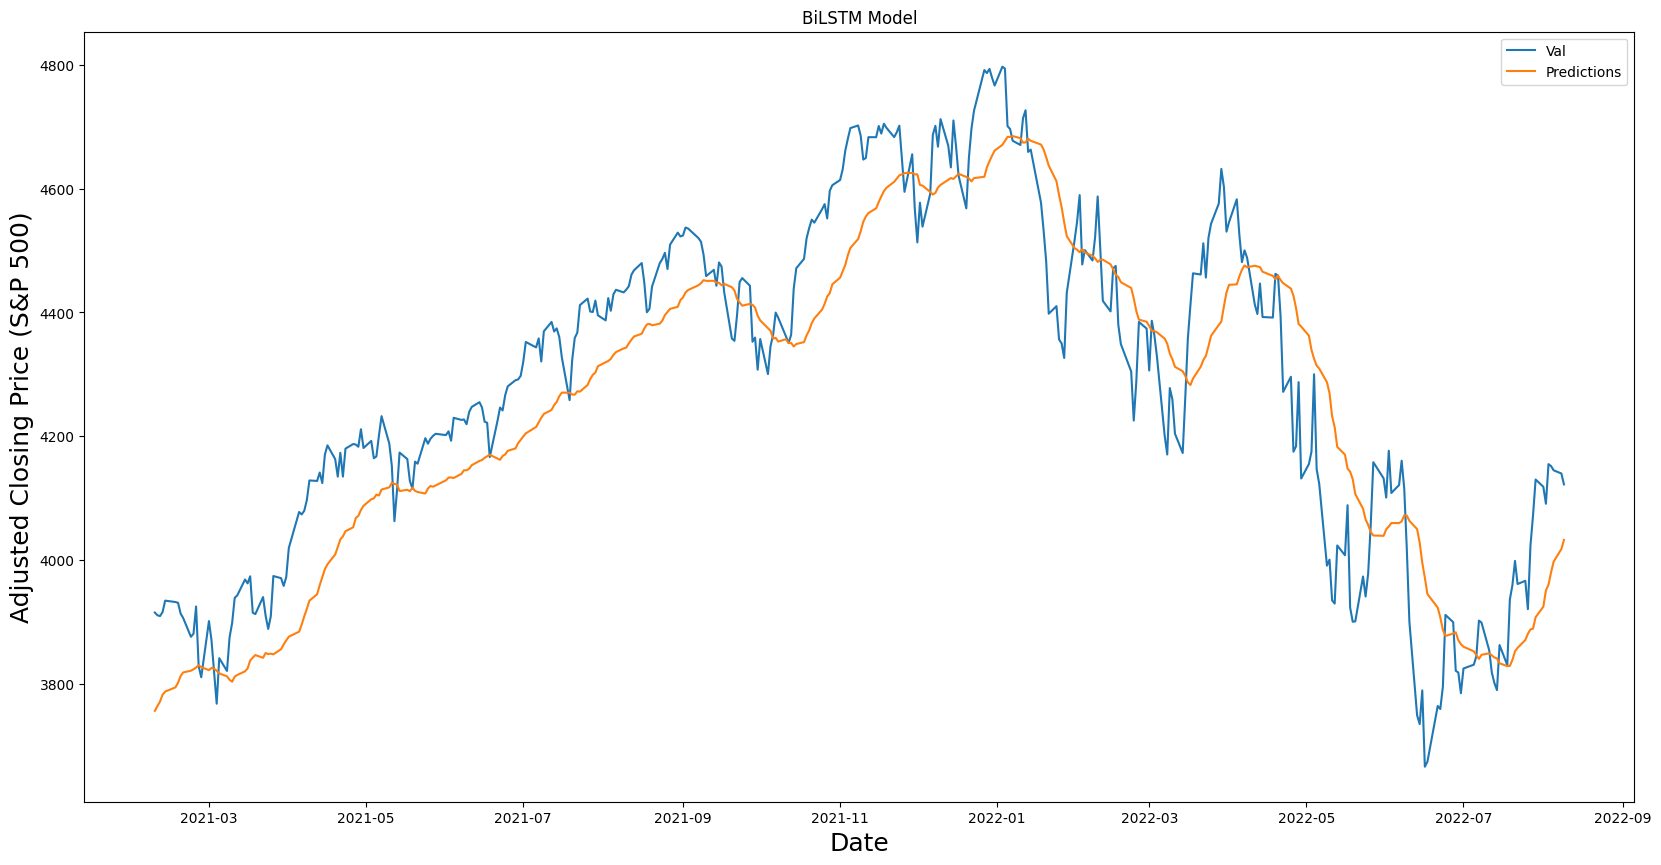

In [ ]:
train = df_1[:training_data_len]
valid = df_1[training_data_len:-testing_data_len]
valid['predictions'] = predictions_BiLSTM
# closing_price_sc = go.Scatter(x=train['date'], y=train['closing_price'])
# layout = go.Layout(title='Closing Price', xaxis=dict(title='Date'), yaxis=dict(title='CP'),width=1000, height=600)
# fig = go.Figure(data=[closing_price_sc], layout=layout)
# iplot(fig)
# print(valid.head())
plt.figure(figsize=(20,10))
plt.title('BiLSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adjusted Closing Price (S&P 500)', fontsize=18)
# plt.plot(train['closing_price'])
plt.plot(valid[['Adj Close', 'predictions']])
plt.legend(['Val', 'Predictions'], loc='upper right')
plt.show()

In [ ]:
#test with test dataset
test_data = scaled_data[-(2*testing_data_len):]
X_test = []
# y_test = dataset.iloc[-testing_data_len:, :].values #not scaled data
for i in range(100, len(2*test_data)):
    X_test.append(test_data[i-100:i,0])
# X_test.append(test_data)


In [ ]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], 25, 4, 1))

In [ ]:
X_test.shape

(100, 25, 4, 1)

In [ ]:
predictions_CNN_BiLSTM = model_CNN_Bilstm.predict(X_test)
predictions_CNN_BiLSTM = scaler.inverse_transform(predictions_CNN_BiLSTM)
predictions_CNN_LSTM = model_CNN_LSTM.predict(X_test)
predictions_CNN_LSTM = scaler.inverse_transform(predictions_CNN_LSTM)
predictions_BiLSTM = model_BiLSTM.predict(X_test)
predictions_BiLSTM = scaler.inverse_transform(predictions_BiLSTM)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [ ]:
y_test = df_2.iloc[-testing_data_len:, :]['Adj Close']
y_test.shape

(100,)

In [ ]:
predictions_CNN_BiLSTM = np.reshape(predictions_CNN_BiLSTM, (100))
predictions_CNN_LSTM = np.reshape(predictions_CNN_LSTM, (100))
predictions_BiLSTM = np.reshape(predictions_BiLSTM, (100))

In [ ]:
rmse_CNNBiLSTM = np.sqrt(np.mean((predictions_CNN_BiLSTM - y_test)**2))
rmse_CNNLSTM = np.sqrt(np.mean((predictions_CNN_LSTM - y_test)**2))
rmse_BiLSTM = np.sqrt(np.mean((predictions_BiLSTM - y_test)**2))
print('The RMSE of CNN_BiLSTM is:')
print(rmse_CNNBiLSTM)
print('The RMSE of CNN_LSTM is:')
print(rmse_CNNLSTM)
print('The RMSE of BiLSTM is:')
print(rmse_BiLSTM)

The RMSE of CNN_BiLSTM is:
75.7640567766322
The RMSE of CNN_LSTM is:
173.59803751488624
The RMSE of BiLSTM is:
132.08331943848484


In [ ]:
MAPE_CNNBiLSTM = MAPE(y_test, predictions_CNN_BiLSTM)
MAPE_CNNLSTM = MAPE(y_test, predictions_CNN_LSTM)
MAPE_BiLSTM = MAPE(y_test, predictions_BiLSTM)
print('The MAPE of CNN_BiLSTM is:')
print(MAPE_CNNBiLSTM)
print('The MAPE of CNN_LSTM is:')
print(MAPE_CNNLSTM)
print('The MAPE of BiLSTM is:')
print(MAPE_BiLSTM)

The MAPE of CNN_BiLSTM is:
1.6223634916458258
The MAPE of CNN_LSTM is:
3.724735381670077
The MAPE of BiLSTM is:
2.9233040805574912


<ipython-input-57-ed396ea8a1fc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = predictions_CNN_BiLSTM


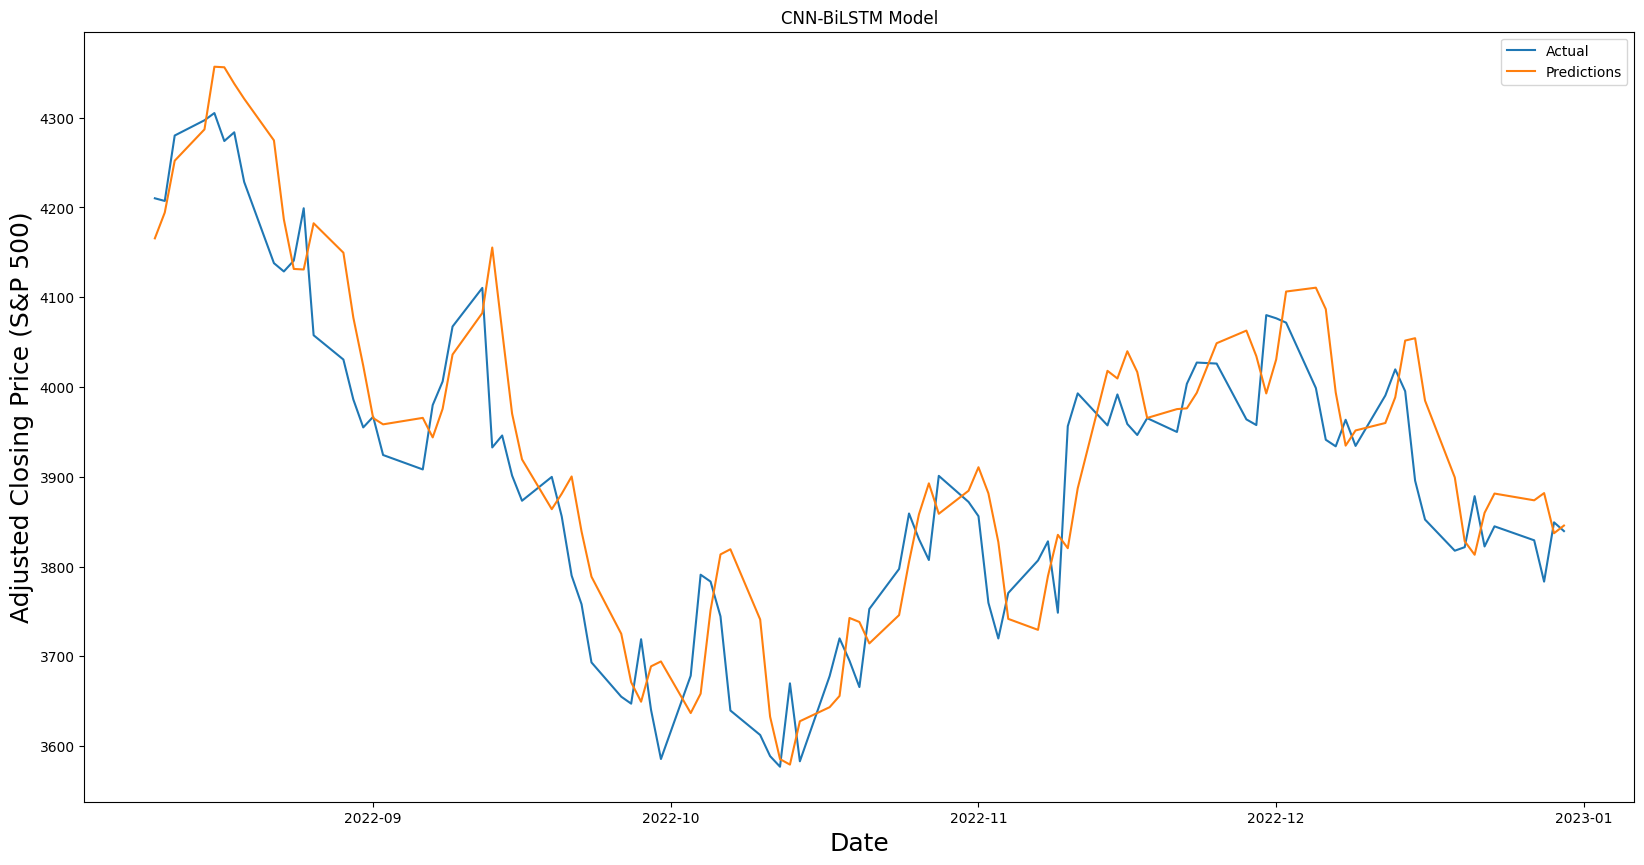

In [ ]:
test = df_1[-testing_data_len:]
test['predictions'] = predictions_CNN_BiLSTM
# closing_price_sc = go.Scatter(x=train['date'], y=train['closing_price'])
# layout = go.Layout(title='Closing Price', xaxis=dict(title='Date'), yaxis=dict(title='CP'),width=1000, height=600)
# fig = go.Figure(data=[closing_price_sc], layout=layout)
# iplot(fig)
# print(valid.head())
plt.figure(figsize=(20,10))
plt.title('CNN-BiLSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adjusted Closing Price (S&P 500)', fontsize=18)
# plt.plot(train['closing_price'])
plt.plot(test[['Adj Close', 'predictions']])
plt.legend(['Actual', 'Predictions'], loc='upper right')
plt.show()


In [ ]:
excel_file_path = "CNN_BiLSTM.xlsx"
test.to_excel(excel_file_path, index=False)

print(f"DataFrame saved as {excel_file_path}")

DataFrame saved as CNN_BiLSTM.xlsx


<ipython-input-59-c1f3f2686704>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = predictions_CNN_LSTM


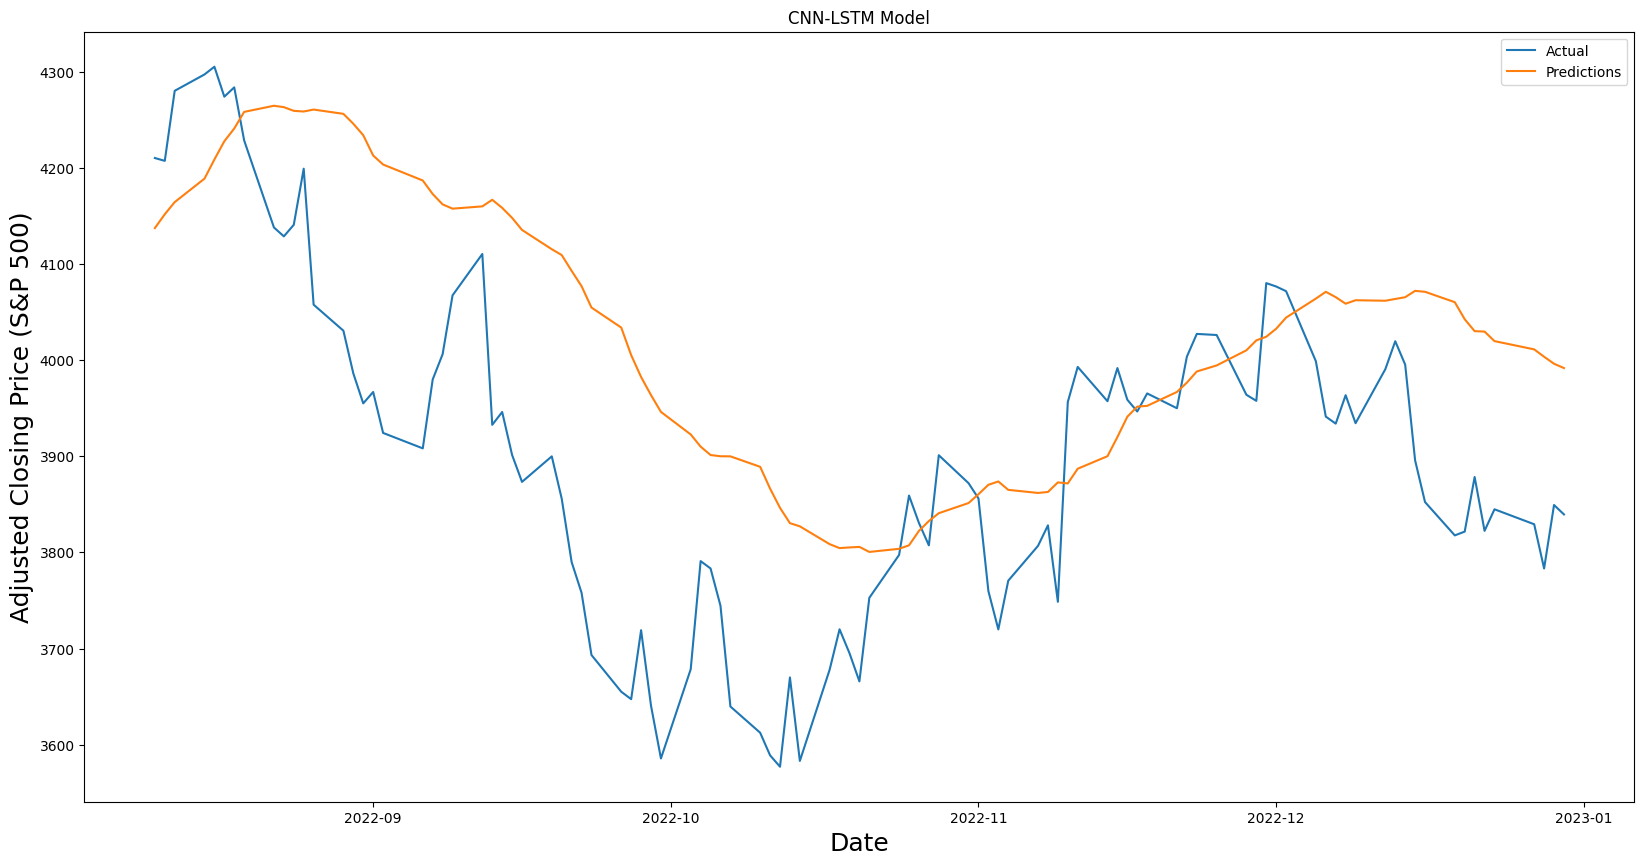

In [ ]:
test = df_1[-testing_data_len:]
test['predictions'] = predictions_CNN_LSTM
# closing_price_sc = go.Scatter(x=train['date'], y=train['closing_price'])
# layout = go.Layout(title='Closing Price', xaxis=dict(title='Date'), yaxis=dict(title='CP'),width=1000, height=600)
# fig = go.Figure(data=[closing_price_sc], layout=layout)
# iplot(fig)
# print(valid.head())
plt.figure(figsize=(20,10))
plt.title('CNN-LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adjusted Closing Price (S&P 500)', fontsize=18)
# plt.plot(train['closing_price'])
plt.plot(test[['Adj Close', 'predictions']])
plt.legend(['Actual', 'Predictions'], loc='upper right')
plt.show()

In [ ]:
excel_file_path = "CNN_LSTM.xlsx"
test.to_excel(excel_file_path, index=False)

print(f"DataFrame saved as {excel_file_path}")

DataFrame saved as CNN_LSTM.xlsx


<ipython-input-61-7bb29c583665>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = predictions_BiLSTM


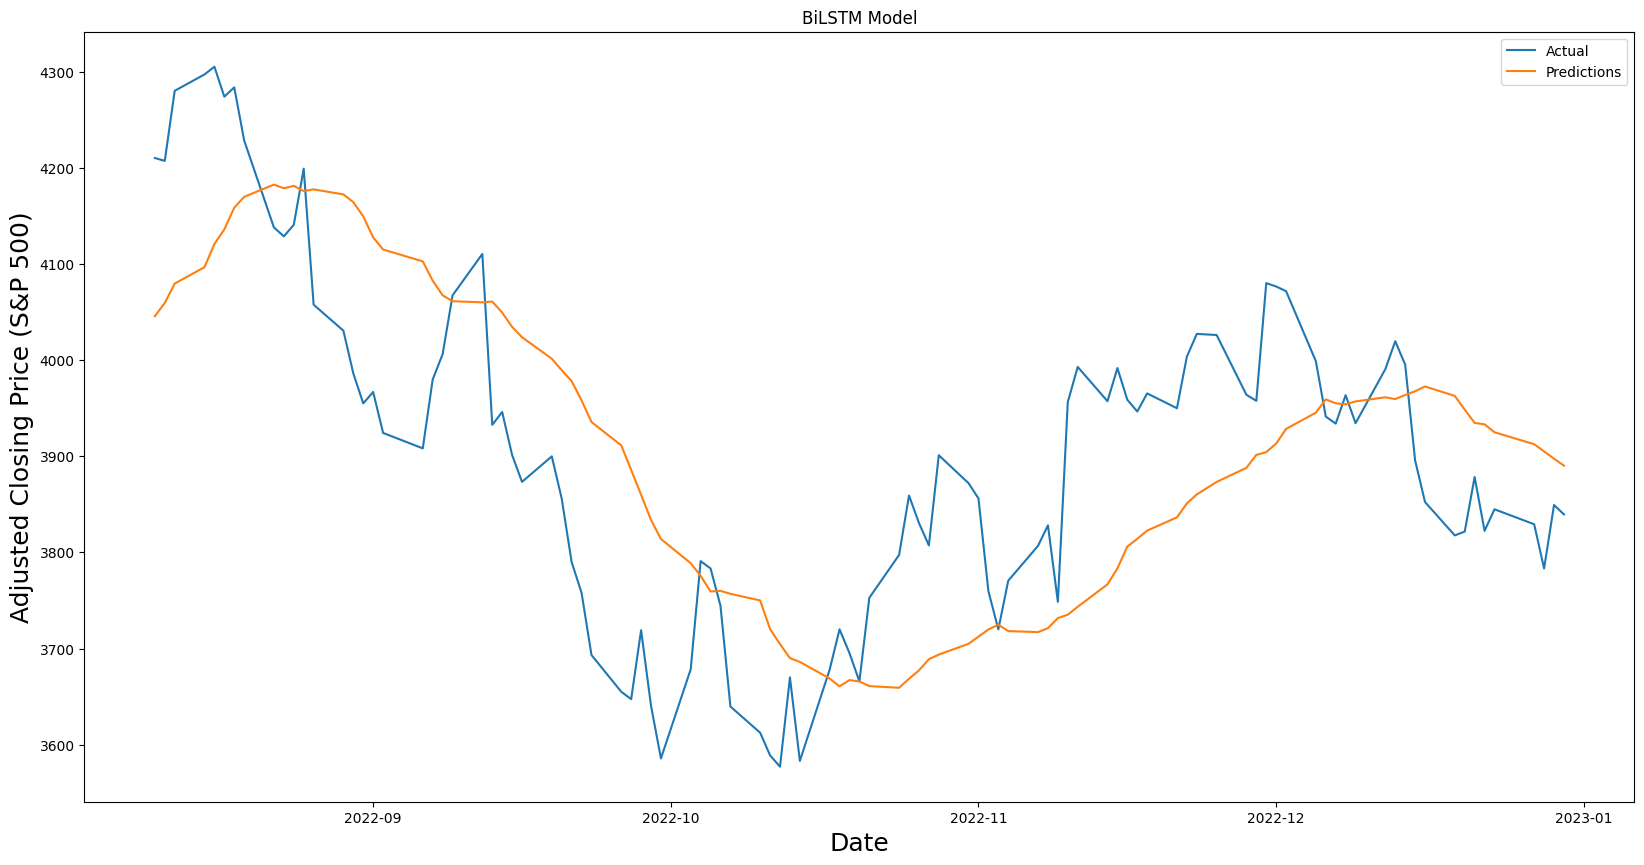

In [ ]:
test = df_1[-testing_data_len:]
test['predictions'] = predictions_BiLSTM
# closing_price_sc = go.Scatter(x=train['date'], y=train['closing_price'])
# layout = go.Layout(title='Closing Price', xaxis=dict(title='Date'), yaxis=dict(title='CP'),width=1000, height=600)
# fig = go.Figure(data=[closing_price_sc], layout=layout)
# iplot(fig)
# print(valid.head())
plt.figure(figsize=(20,10))
plt.title('BiLSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adjusted Closing Price (S&P 500)', fontsize=18)
# plt.plot(train['closing_price'])
plt.plot(test[['Adj Close', 'predictions']])
plt.legend(['Actual', 'Predictions'], loc='upper right')
plt.show()

In [ ]:
excel_file_path = "BiLSTM.xlsx"
test.to_excel(excel_file_path)

print(f"DataFrame saved as {excel_file_path}")

DataFrame saved as BiLSTM.xlsx
